# preprocessing

In [128]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from sklearn.metrics import mean_squared_error
from math import sqrt



%matplotlib inline
pd.options.display.max_columns = None


In [129]:
data = pd.read_csv('wholedata_xgboost.csv')
print(data.shape)
data.head()

(18249, 17)


,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,winter,spring,summer,autumn
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,2015,Albany,12,1,0,0,0
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,2015,Albany,12,1,0,0,0
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,2015,Albany,12,1,0,0,0
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,2015,Albany,12,1,0,0,0
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,2015,Albany,11,1,0,0,0


## train, test split

In [130]:
X = data.drop('AveragePrice',axis=1)
feature_list = list(X.columns)
print(len(feature_list))
y = data['AveragePrice']

print(X.shape,y.shape)

16
(18249, 16) (18249,)


In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
print(X_train.shape, y_train.shape)
print('---------------------')
print(X_test.shape, y_test.shape)

(14599, 16) (14599,)
---------------------
(3650, 16) (3650,)


## make a function of RMSE

In [132]:
def RMSE(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# XGBoost

In [133]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import KFold, train_test_split

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## label encoder

In [134]:
from sklearn.preprocessing import LabelEncoder

In [135]:
le = LabelEncoder()
le.fit(X_train['region'])
X_train['region'] = le.transform(X_train['region'])

X_test['region'] = le.transform(X_test['region'])

In [136]:
X_train.head()

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,winter,spring,summer,autumn
8621,1140210.38,587439.51,258369.66,5543.59,288857.62,183640.29,104915.08,302.25,0,2018,11,1,1,0,0,0
17043,25301.81,729.00,12909.58,11.45,11651.78,484.21,11167.57,0.00,1,2017,43,7,0,0,1,0
6434,3014558.52,557159.67,1180490.16,267511.89,1009396.80,647895.99,296531.31,64969.50,0,2017,15,7,0,0,1,0
5740,653598.86,51628.46,402657.24,5171.88,194141.28,192627.66,800.29,713.33,0,2017,2,8,0,0,0,1
11019,18054.18,6605.19,10611.69,0.00,837.30,0.00,837.30,0.00,1,2015,36,8,0,0,0,1


In [137]:
X_test.head()

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,winter,spring,summer,autumn
17013,19433.90,7271.61,8960.86,2.88,3198.55,3198.55,0.00,0.00,1,2017,42,2,0,1,0,0
1152,2617806.65,1232603.24,914725.31,74252.61,396225.49,378048.56,13371.54,4805.39,0,2015,22,11,1,0,0,0
11868,194132.30,69519.19,82145.27,78.72,42389.12,8993.07,33396.05,0.00,1,2015,52,4,0,1,0,0
14351,71367.79,20353.71,13495.03,848.58,36670.47,22878.16,13792.31,0.00,1,2016,46,6,0,0,1,0
9038,4199974.24,2420770.45,355406.02,16642.51,1407155.26,901796.49,485922.10,19436.67,0,2018,46,1,1,0,0,0


## basic Xgboost model

## Dmatrix

In [138]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test,y_test)

## Cross validation

In [139]:
xgb_params = {
    'seed': 2020
}

In [140]:
%%time


        

bst_cv1 = xgb.cv(xgb_params, dtrain, nfold=5, seed=2020)
#- num_boost_round： 一个整数，表示boosting 迭代数量   i.e. 树的个数
print ('CV score_train:', bst_cv1.iloc[-1,:]['train-rmse-mean'])
print ('CV score_test:', bst_cv1.iloc[-1,:]['test-rmse-mean'])

CV score_train: 0.1672602
CV score_test: 0.183451
CPU times: user 3.42 s, sys: 76 ms, total: 3.49 s
Wall time: 619 ms


Text(0.5, 0, 'number of rounds')

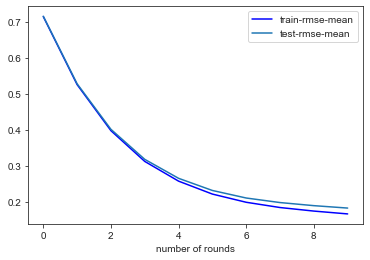

In [141]:
plt.figure()
plt.plot(bst_cv1['train-rmse-mean'],color = 'blue',label="train-rmse-mean")
plt.plot(bst_cv1['test-rmse-mean'],label="test-rmse-mean")
plt.legend()
plt.xlabel('number of rounds')

# tune

## num_boost_round -20

In [142]:
%%time


        

bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=5, seed=2020)
#- num_boost_round： 一个整数，表示boosting 迭代数量   i.e. 树的个数
print ('CV score_train:', bst_cv2.iloc[-1,:]['train-rmse-mean'])
print ('CV score_test:', bst_cv2.iloc[-1,:]['test-rmse-mean'])

CV score_train: 0.0974584
CV score_test: 0.13650020000000002
CPU times: user 14.2 s, sys: 155 ms, total: 14.4 s
Wall time: 2.16 s


Text(0.5, 0, 'number of rounds')

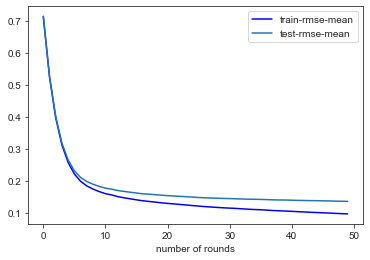

In [143]:
plt.figure()
plt.plot(bst_cv2['train-rmse-mean'],color = 'blue',label="train-rmse-mean")
plt.plot(bst_cv2['test-rmse-mean'],label="test-rmse-mean")
plt.legend()
plt.xlabel('number of rounds')
#here the train or test are the kfold's train and test

In [144]:
%%time


        

bst_cv3 = xgb.cv(xgb_params, dtrain, num_boost_round=20, nfold=5, seed=2020)
#- num_boost_round： 一个整数，表示boosting 迭代数量   i.e. 树的个数
print ('CV score_train:', bst_cv3.iloc[-1,:]['train-rmse-mean'])
print ('CV score_test:', bst_cv3.iloc[-1,:]['test-rmse-mean'])
print ('CV score_difference:', abs(bst_cv3.iloc[-1,:]['test-rmse-mean']-bst_cv3.iloc[-1,:]['train-rmse-mean']) )

CV score_train: 0.1322224
CV score_test: 0.155998
CV score_difference: 0.023775600000000008
CPU times: user 5.43 s, sys: 35.1 ms, total: 5.47 s
Wall time: 767 ms


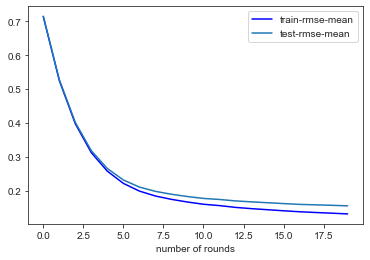

In [145]:
plt.figure()
plt.plot(bst_cv3['train-rmse-mean'],color = 'blue',label="train-rmse-mean")
plt.plot(bst_cv3['test-rmse-mean'],label="test-rmse-mean")
plt.legend()
plt.xlabel('number of rounds')
plt.savefig('.png')
#here the train or test are the kfold's train and test

In [146]:
%%time


        

bst_cv3 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5, seed=2020)
#- num_boost_round： 一个整数，表示boosting 迭代数量   i.e. 树的个数
print ('CV score_train:', bst_cv3.iloc[-1,:]['train-rmse-mean'])
print ('CV score_test:', bst_cv3.iloc[-1,:]['test-rmse-mean'])
print ('CV score_difference:', abs(bst_cv3.iloc[-1,:]['test-rmse-mean']-bst_cv3.iloc[-1,:]['train-rmse-mean']) )

CV score_train: 0.0735908
CV score_test: 0.12866
CV score_difference: 0.0550692
CPU times: user 30.3 s, sys: 294 ms, total: 30.6 s
Wall time: 4.51 s


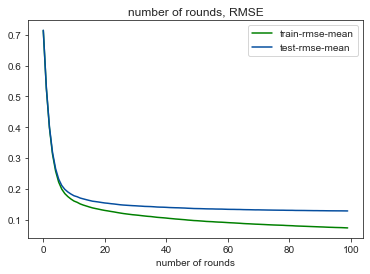

In [147]:
plt.figure()
plt.plot(bst_cv3['train-rmse-mean'],color = 'green',label="train-rmse-mean")
plt.plot(bst_cv3['test-rmse-mean'],color = '#054E9F',label="test-rmse-mean")
plt.legend()
plt.xlabel('number of rounds')
plt.title('number of rounds, RMSE')
plt.savefig('number of rounds.png')
#here the train or test are the kfold's train and test

num_boost_round  = 20

## class

In [148]:
class XGBoostRegressor():
    # __init__ double underscore
    def __init__(self, **kwargs):
        self.params = kwargs
        #kwargs represents as a dictionary 
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed':2020})
    
    def fit(self, xtrain, ytrain):
        dtrain = xgb.DMatrix(xtrain,ytrain)
        self.model = xgb.train(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round)
    
    def predict(self,x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.model.predict(dpred)
    
    def kfold(self, xtrain, ytrain, nfold=5):
        dtrain = xgb.DMatrix(xtrain,ytrain)
        cv_rounds = xgb.cv(self.params,dtrain=dtrain, num_boost_round=self.num_boost_round, seed=2020)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importance(self,max_num_features=5):
        fig, ax1 = plt.subplots(figsize=(16,25))
        xgb.plot_importance(self.model, height=0.2,ax=ax1, xlim=None, ylim=None,
       title='Feature importance', xlabel='F score', ylabel='Features',
       importance_type='weight', max_num_features=max_num_features, grid=True, 
       show_values=True)
        
    def get_params(self,deep=False):
        return self.params
    
    def set_params(self, **params):
        self.params.update(params)
        return self


In [149]:
bst = XGBoostRegressor(num_boost_round=20)
bst.kfold(X_train, y_train, nfold=5)

train-rmse-mean    0.130016
train-rmse-std     0.000432
test-rmse-mean     0.157160
test-rmse-std      0.001013
Name: 19, dtype: float64

In [150]:
bst.fit(X_train, y_train)

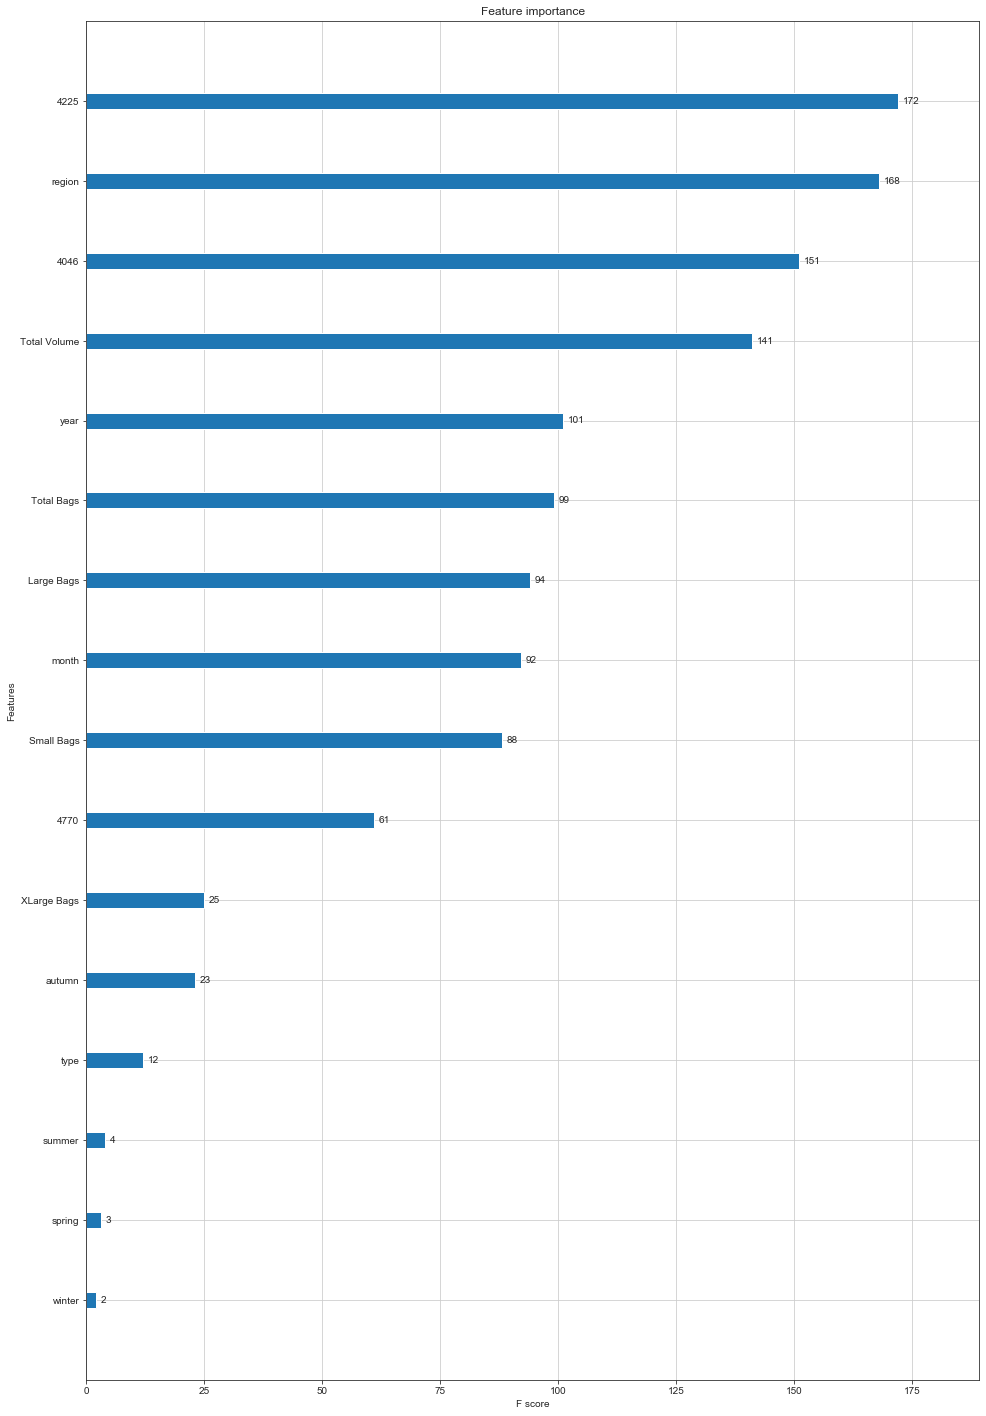

In [151]:
bst.plot_feature_importance(max_num_features=None)

## the depth and weight (树的complexity) - 10, 5

In [167]:
xgb_param_grid = {'max_depth': list(range(4,12)), 'min_child_weight': list((1,2,3,4,5,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8, 9, 10, 11]

In [168]:
from sklearn.metrics import make_scorer
RMSE_scorer = make_scorer(RMSE, greater_is_better=False)

In [169]:
%%time
 
grid = GridSearchCV(XGBoostRegressor(num_boost_round=20),
                    param_grid=xgb_param_grid, cv=5,scoring=RMSE_scorer)

grid.fit(X_train.values, y_train.values)


CPU times: user 5min 50s, sys: 1.91 s, total: 5min 52s
Wall time: 47.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a2f2c3090>,
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11],
                         'min_child_weight': [1, 2, 3, 4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [170]:
print(grid.best_params_, grid.best_score_)

{'max_depth': 10, 'min_child_weight': 5} -0.13010451768802536


In [171]:
bst = XGBoostRegressor(num_boost_round=20, max_depth=10, min_child_weight=5)
bst.kfold(X_train, y_train, nfold=5)

train-rmse-mean    0.057571
train-rmse-std     0.001241
test-rmse-mean     0.136825
test-rmse-std      0.001655
Name: 19, dtype: float64

In [172]:
scores = abs(grid.cv_results_['mean_test_score'])
scores = scores.reshape(8,6)

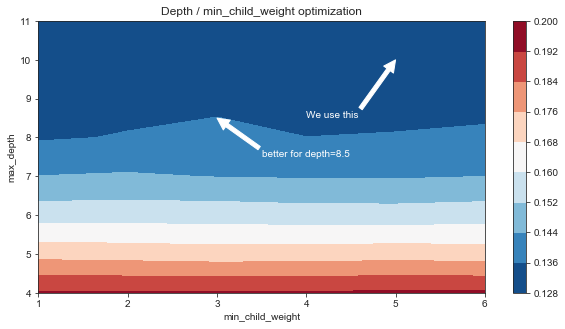

In [177]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='RdBu_r')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5, 10), xytext=(4, 8.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('better for depth=8.5', xy=(3, 8.5), 
             xytext=(3.5, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

## tune gamma to reduce the risk of overfitting - 0

In [207]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,6)]}

grid = GridSearchCV(XGBoostRegressor(num_boost_round=20, max_depth=10, min_child_weight=5),
                    param_grid=xgb_param_grid, cv=5, scoring=RMSE_scorer)

grid.fit(X_train, y_train.values)

CPU times: user 56.4 s, sys: 402 ms, total: 56.8 s
Wall time: 7.56 s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a37a673d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                   0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [208]:
grid.best_params_,grid.best_score_

({'gamma': 0.0}, -0.13010451768802536)

In [209]:
grid.cv_results_['mean_test_score']

array([-0.13010452, -0.13576848, -0.14045094, -0.14586007, -0.14840336,
       -0.15257266])

## tune the subsample and colsample_bytree -1,1

In [214]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(9,11)],
                 'colsample_bytree':[ 0.1 * i for i in range(9,11)]}

grid = GridSearchCV(XGBoostRegressor(num_boost_round=20, max_depth=10, min_child_weight=5,
                                        gamma = 0),
                    param_grid=xgb_param_grid, cv=5, scoring=RMSE_scorer)

grid.fit(X_train, y_train)

CPU times: user 34.1 s, sys: 172 ms, total: 34.3 s
Wall time: 4.42 s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a342a4610>,
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.9, 1.0],
                         'subsample': [0.9, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [215]:
grid.best_params_,grid.best_score_

({'colsample_bytree': 1.0, 'subsample': 1.0}, -0.13010451768802536)

## learning rate and number of rounds

In [216]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=20, gamma=0, max_depth=10, min_child_weight=5),
                    param_grid=xgb_param_grid, cv=5, scoring=RMSE_scorer)

grid.fit(X_train, y_train)

CPU times: user 1min 32s, sys: 1.01 s, total: 1min 33s
Wall time: 13 s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a37716e90>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [217]:
grid.best_params_,grid.best_score_

({'eta': 0.3}, -0.13010451768802536)

In [218]:
eta = grid.cv_results_['param_eta']
eta = np.array(eta)
eta = eta.astype(np.float64)
eta 

array([0.5  , 0.4  , 0.3  , 0.2  , 0.1  , 0.075, 0.05 , 0.04 , 0.03 ])

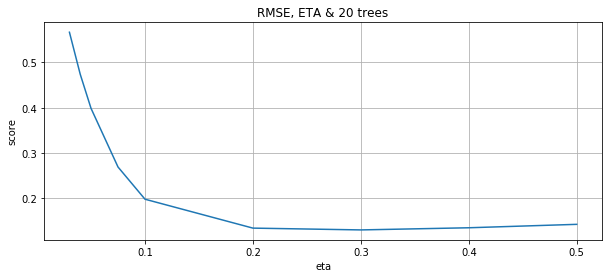

In [219]:
y = grid.cv_results_['mean_test_score']
plt.figure(figsize=(10,4))
plt.title('RMSE, ETA & 20 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [244]:
%%time 

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=60, gamma=0, max_depth=10, min_child_weight=5),
                    param_grid=xgb_param_grid, cv=5, scoring=RMSE_scorer)

grid.fit(X_train, y_train) 

CPU times: user 4min 31s, sys: 2.33 s, total: 4min 34s
Wall time: 38 s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a3169af10>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [245]:
grid.best_params_, grid.best_score_

({'eta': 0.2}, -0.12491506773753858)

In [246]:
eta = grid.cv_results_['param_eta']
eta = np.array(eta)
eta = eta.astype(np.float64)
eta 

array([0.5  , 0.4  , 0.3  , 0.2  , 0.1  , 0.075, 0.05 , 0.04 , 0.03 ])

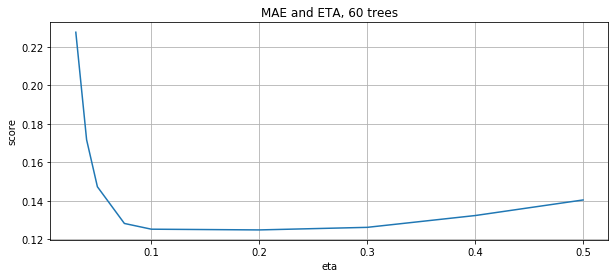

In [247]:
y = grid.cv_results_['mean_test_score']
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 60 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [248]:
%%time 

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0, max_depth=10, min_child_weight=5),
                    param_grid=xgb_param_grid, cv=5, scoring=RMSE_scorer)

grid.fit(X_train, y_train) 

CPU times: user 7min 23s, sys: 2.97 s, total: 7min 26s
Wall time: 1min


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a317c4590>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [249]:
grid.best_params_, grid.best_score_

({'eta': 0.1}, -0.12241722594839324)

In [250]:
eta = grid.cv_results_['param_eta']
eta = np.array(eta)
eta = eta.astype(np.float64)
eta 

array([0.5  , 0.4  , 0.3  , 0.2  , 0.1  , 0.075, 0.05 , 0.04 , 0.03 ])

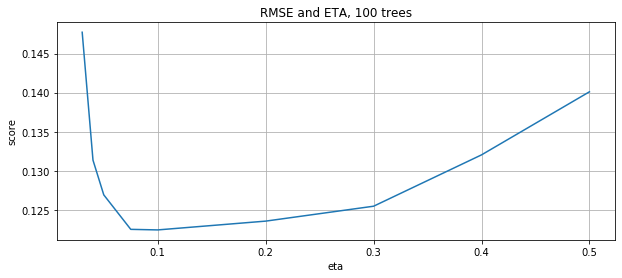

In [251]:
y = grid.cv_results_['mean_test_score']
plt.figure(figsize=(10,4))
plt.title('RMSE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [252]:
%%time 

xgb_param_grid = {'eta':[0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0, max_depth=10, min_child_weight=5),
                    param_grid=xgb_param_grid, cv=5, scoring=RMSE_scorer)

grid.fit(X_train, y_train) 

CPU times: user 6min 35s, sys: 2.36 s, total: 6min 38s
Wall time: 52.7 s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a30d68910>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                                 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [253]:
grid.best_params_, grid.best_score_

({'eta': 0.09}, -0.12222681782608769)

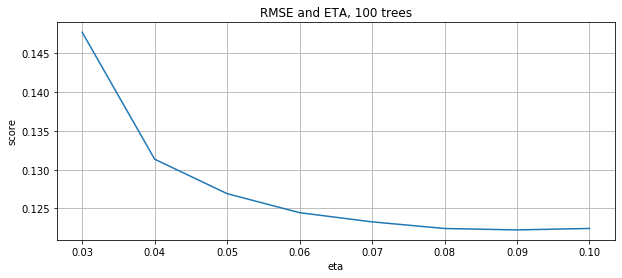

In [254]:
eta = grid.cv_results_['param_eta']
eta = np.array(eta)
eta = eta.astype(np.float64)
y = grid.cv_results_['mean_test_score']
plt.figure(figsize=(10,4))
plt.title('RMSE and ETA, 100 trees') 
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

### test different num_boost_round|

In [190]:
%%time 

xgb_param_grid = {'eta':[0.1,0.09,0.08,0.075,0.07,0.065,0.06,0.055]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=150, gamma=0, max_depth=10, min_child_weight=5),
                    param_grid=xgb_param_grid, cv=5, scoring=RMSE_scorer)

grid.fit(X_train, y_train) 

CPU times: user 9min 18s, sys: 1.96 s, total: 9min 20s
Wall time: 1min 12s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x1a2dee7dd0>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.1, 0.09, 0.08, 0.075, 0.07, 0.065, 0.06,
                                 0.055]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [191]:
grid.best_params_, grid.best_score_

({'eta': 0.09}, -0.12066961413879362)

In [192]:
eta = grid.cv_results_['param_eta']
eta = np.array(eta)
eta = eta.astype(np.float64)
eta 

array([0.1  , 0.09 , 0.08 , 0.075, 0.07 , 0.065, 0.06 , 0.055])

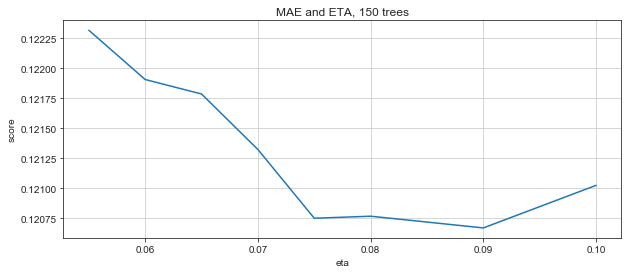

In [193]:
y = grid.cv_results_['mean_test_score']
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 150 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

# model

In [208]:
TrainModel=XGBoostRegressor(num_boost_round=100, gamma=0, max_depth=10, min_child_weight=5, cv=5,eta=0.09)
TrainModel.kfold(X_train, y_train, nfold=5) 

train-rmse-mean    0.044283
train-rmse-std     0.000674
test-rmse-mean     0.126670
test-rmse-std      0.000897
Name: 99, dtype: float64

In [209]:
TrainModel.fit(X_train,y_train)
TrainModel.predict(X_test)

array([2.3955293 , 0.84180796, 1.4630561 , ..., 1.612867  , 1.4095157 ,
       1.4563055 ], dtype=float32)

In [210]:
RMSE(y_test,TrainModel.predict(X_test))

0.11779775641277462

In [211]:
models = [] 
models.append(('XGB',XGBRegressor(objective ='reg:squarederror',
                                  num_boost_round=100, gamma=0, max_depth=10, min_child_weight=5, cv=5,eta=0.09)))

In [212]:
models 

[('XGB', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, cv=5, eta=0.09, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=10, min_child_weight=5, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, num_boost_round=100,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
               subsample=1, verbosity=1))]

In [213]:
from sklearn.model_selection import cross_val_score
results = [] 
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=2020) 
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=RMSE_scorer) 
    results.append(cv_results) 
    names.append(name) 
    print(results)
    print("Model Name:{} Model Score:{:.4f} Model Std:{:.4f}".format(name, cv_results.mean()*-1, cv_results.std()))

[array([-0.11911826, -0.11325605, -0.12419973, -0.11863537, -0.12046035,
       -0.11920651, -0.11751655, -0.11845687, -0.12474027, -0.12465232])]
Model Name:XGB Model Score:0.1200 Model Std:0.0035


In [214]:
resultsabs = [x*-1 for x in results]
resultsabs

[array([0.11911826, 0.11325605, 0.12419973, 0.11863537, 0.12046035,
        0.11920651, 0.11751655, 0.11845687, 0.12474027, 0.12465232])]

In [215]:
dfresultsabs = pd.DataFrame(resultsabs).values 
dfresultsabs = dfresultsabs.reshape(-1,1)
dfresultsabs

array([[0.11911826],
       [0.11325605],
       [0.12419973],
       [0.11863537],
       [0.12046035],
       [0.11920651],
       [0.11751655],
       [0.11845687],
       [0.12474027],
       [0.12465232]])

Text(0, 0.5, 'Scores')

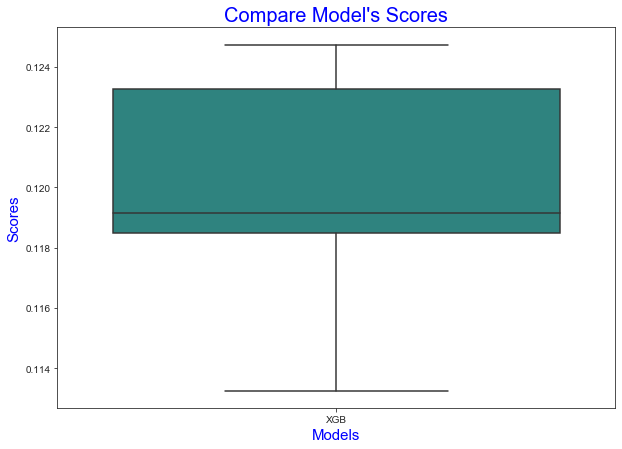

In [216]:
f,ax = plt.subplots(figsize = (10,7))
sns.boxplot(x=names, y=resultsabs,palette="viridis");
plt.title("Compare Model's Scores",fontsize = 20,color='blue')
plt.xlabel('Models',fontsize = 15,color='blue')
plt.ylabel('Scores',fontsize = 15,color='blue')

In [199]:
# rf

rfdata = pd.read_csv('wholedata.csv')
print(rfdata.shape)  
rfdata.head() 

(18249, 70)


,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,month,winter,spring,summer,autumn,region_Albany,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,region_California,region_Charlotte,region_Chicago,region_CincinnatiDayton,region_Columbus,region_DallasFtWorth,region_Denver,region_Detroit,region_GrandRapids,region_GreatLakes,region_HarrisburgScranton,region_HartfordSpringfield,region_Houston,region_Indianapolis,region_Jacksonville,region_LasVegas,region_LosAngeles,region_Louisville,region_MiamiFtLauderdale,region_Midsouth,region_Nashville,region_NewOrleansMobile,region_NewYork,region_Northeast,region_NorthernNewEngland,region_Orlando,region_Philadelphia,region_PhoenixTucson,region_Pittsburgh,region_Plains,region_Portland,region_RaleighGreensboro,region_RichmondNorfolk,region_Roanoke,region_Sacramento,region_SanDiego,region_SanFrancisco,region_Seattle,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,2015,12,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,2015,12,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,2015,12,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,2015,12,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,2015,11,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [200]:
rf_X = rfdata.drop('AveragePrice',axis=1)
feature_list = list(rf_X.columns)  
print(len(feature_list)) 

rf_y = rfdata['AveragePrice'] 

rf_X = rf_X.values
rf_y = rf_y.values
print(rf_X.shape,rf_y.shape) 

69
(18249, 69) (18249,)


In [201]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size=0.2, random_state=2020)
print(rf_X_train.shape, rf_y_train.shape)
print('---------------------')
print(rf_X_test.shape, rf_y_test.shape)

(14599, 69) (14599,)
---------------------
(3650, 69) (3650,)


In [202]:
from sklearn.ensemble import RandomForestRegressor
rfs = []  
rfs.append(('Random Forest',RandomForestRegressor(n_estimators=1000,min_samples_split=2,min_samples_leaf=1,max_features=41,
                              bootstrap=True,n_jobs= -1)))

In [203]:
rf = RandomForestRegressor(n_estimators=1000,min_samples_split=2,min_samples_leaf=1,max_features=41,
                              bootstrap=True,n_jobs= -1)

In [204]:
rfs 

[('Random Forest',
  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features=41, max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=1000, n_jobs=-1, oob_score=False,
                        random_state=None, verbose=0, warm_start=False))]

In [205]:
from sklearn.model_selection import cross_val_score
rf_results = []  
rf_names = [] 
for name, model in rfs:
    kfold = KFold(n_splits=10, random_state=2020) 
    cv_results = cross_val_score(model, rf_X_train, rf_y_train, cv=kfold, scoring=RMSE_scorer) 
    rf_results.append(cv_results) 
    rf_names.append(name) 
    print(rf_results) 
    print("Model Name:{} Model Score:{:.4f} Model Std:{:.4f}".format(name, cv_results.mean()*-1, cv_results.std()))  
    
    

[array([-0.12127935, -0.11923538, -0.12581674, -0.12016937, -0.12207739,
       -0.12933503, -0.12032405, -0.12210659, -0.12524517, -0.12743599])]
Model Name:Random Forest Model Score:0.1233 Model Std:0.0033


In [206]:
rf_resultsabs = [x*-1 for x in rf_results]
rf_resultsabs 

[array([0.12127935, 0.11923538, 0.12581674, 0.12016937, 0.12207739,
        0.12933503, 0.12032405, 0.12210659, 0.12524517, 0.12743599])]

Text(0, 0.5, 'Scores')

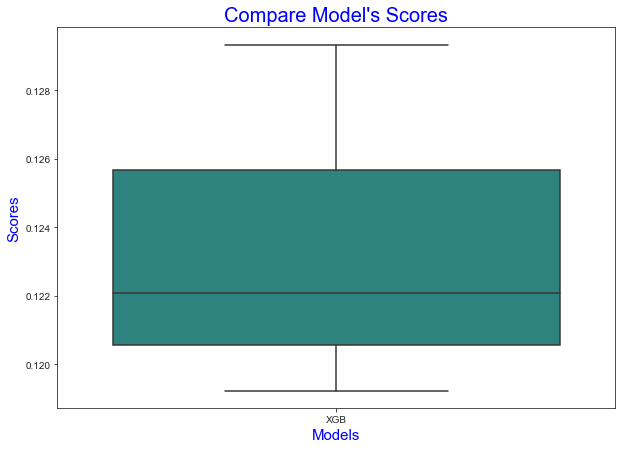

In [217]:
f,ax = plt.subplots(figsize = (10,7))
sns.boxplot(x=names, y=rf_resultsabs,palette="viridis")
plt.title("Compare Model's Scores",fontsize = 20,color='blue')
plt.xlabel('Models',fontsize = 15,color='blue')
plt.ylabel('Scores',fontsize = 15,color='blue')

In [218]:
dfrf_resultsabs = pd.DataFrame(rf_resultsabs).values 
dfrf_resultsabs = dfrf_resultsabs.reshape(-1,1)
dfrf_resultsabs

array([[0.12127935],
       [0.11923538],
       [0.12581674],
       [0.12016937],
       [0.12207739],
       [0.12933503],
       [0.12032405],
       [0.12210659],
       [0.12524517],
       [0.12743599]])

In [219]:
result = np.concatenate((dfresultsabs,dfrf_resultsabs),axis = 1)
result

array([[0.11911826, 0.12127935],
       [0.11325605, 0.11923538],
       [0.12419973, 0.12581674],
       [0.11863537, 0.12016937],
       [0.12046035, 0.12207739],
       [0.11920651, 0.12933503],
       [0.11751655, 0.12032405],
       [0.11845687, 0.12210659],
       [0.12474027, 0.12524517],
       [0.12465232, 0.12743599]])

In [220]:
dfresult = pd.DataFrame(result)
dfresult.columns = ['XGBoost','Random Forest']
dfresult

,XGBoost,Random Forest
0,0.119118,0.121279
1,0.113256,0.119235
2,0.124200,0.125817
3,0.118635,0.120169
4,0.120460,0.122077
5,0.119207,0.129335
6,0.117517,0.120324
7,0.118457,0.122107
8,0.124740,0.125245
9,0.124652,0.127436


In [221]:
dfresult.to_csv('result.csv',index=None)

In [222]:
dfresult = pd.read_csv('result.csv')

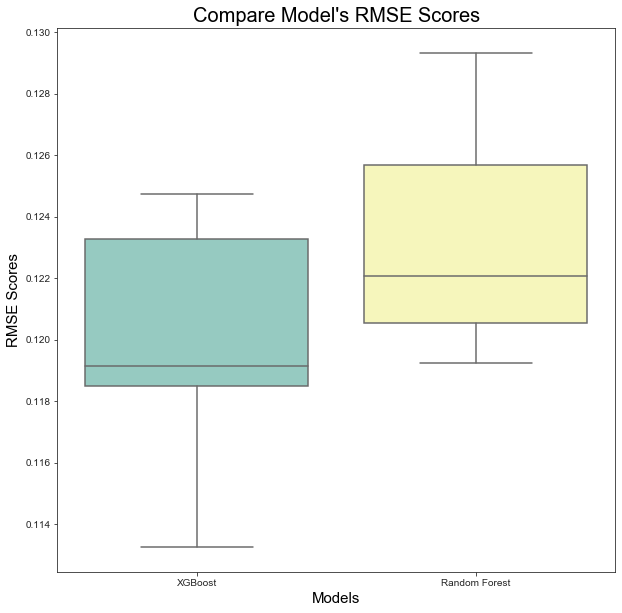

In [224]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=dfresult,orient="v",palette="Set3") 
plt.title("Compare Model's RMSE Scores",fontsize = 20,color='black')
plt.xlabel('Models',fontsize = 15,color='black')
plt.ylabel('RMSE Scores',fontsize = 15,color='black') 
plt.savefig('scatter.png')
plt.savefig('compare model\'s RMSE.png')

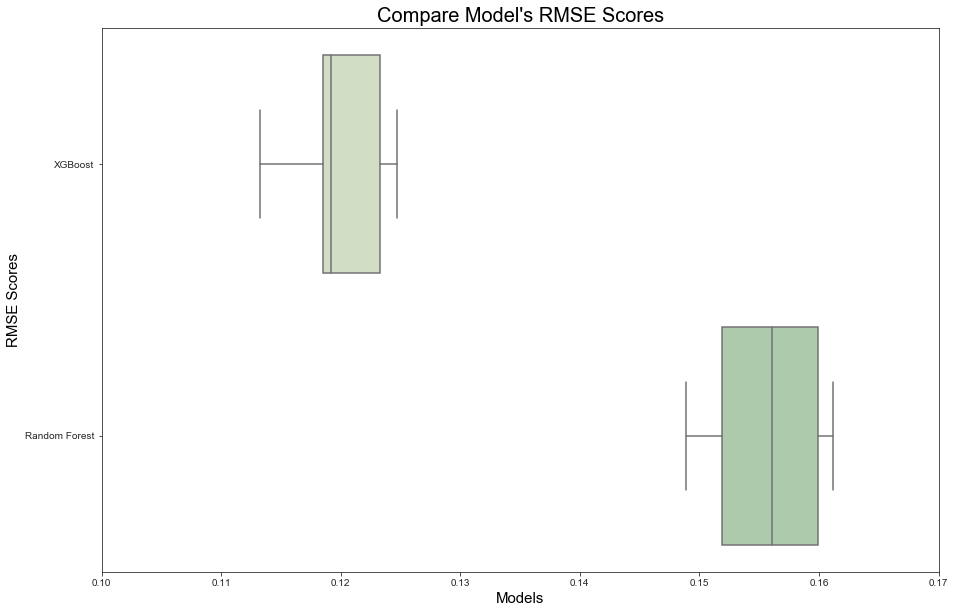

In [99]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=dfresult,orient="h",palette=sns.cubehelix_palette(8, start=.6, rot=-.75))
plt.title("Compare Model's RMSE Scores",fontsize = 20,color='black')
plt.xlabel('Models',fontsize = 15,color='black')
plt.ylabel('RMSE Scores',fontsize = 15,color='black')  

plt.xlim(xmin = 0.1)
plt.xlim(xmax = 0.17)
plt.savefig('scatter1.png')

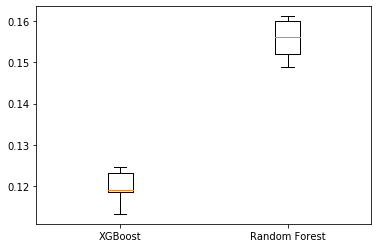

In [8]:
plt.boxplot(x=dfresult.values,labels=dfresult.columns,whis=1.5)
plt.show()

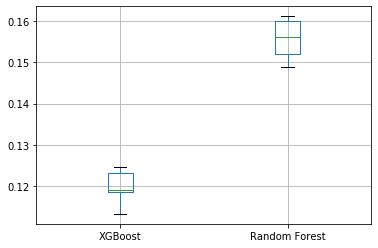

In [9]:
dfresult.boxplot()
plt.show()

In [ ]:
}